In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim

In [293]:
sample = pd.read_csv('/content/sample_submission.csv')
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [294]:
train = train.dropna(ignore_index=True)
train = train.drop_duplicates()

test = test.fillna(0)

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26900 entries, 0 to 26899
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          26900 non-null  int64  
 1   person_age                  26900 non-null  float64
 2   person_income               26900 non-null  float64
 3   person_home_ownership       26900 non-null  object 
 4   person_emp_length           26900 non-null  float64
 5   loan_intent                 26900 non-null  object 
 6   loan_grade                  26900 non-null  object 
 7   loan_amnt                   26900 non-null  float64
 8   loan_int_rate               26900 non-null  float64
 9   loan_percent_income         26900 non-null  float64
 10  cb_person_default_on_file   26900 non-null  object 
 11  cb_person_cred_hist_length  26900 non-null  float64
 12  loan_status                 26900 non-null  int64  
dtypes: float64(7), int64(2), object

In [295]:
n = 0
for _ in train.columns:
  if n > 0: print(f"{_}\n {train[f"{_}"].unique()} \n")
  n += 1

person_age
 [24. 27. 29. 30. 22. 28. 37. 36. 23. 34. 26. 54. 25. 50. 21. 31. 33. 35.
 42. 44. 41. 43. 56. 38. 47. 32. 48. 40. 39. 45. 58. 66. 55. 52. 57. 51.
 46. 49. 53. 61. 62. 60. 59. 65. 63. 64.] 

person_income
 [ 91352.  48613. 150931. ...  59094.  34617. 131087.] 

person_home_ownership
 ['OTHER' 'RENT' 'MORTGAGE' 'OWN'] 

person_emp_length
 [ 1.23122091  7.78026062 14.48705338 ...  1.67378923  3.28110727
  4.98105141] 

loan_intent
 ['DEBTCONSOLIDATION' 'VENTURE' 'PERSONAL' 'EDUCATION' 'HOMEIMPROVEMENT'
 'MEDICAL'] 

loan_grade
 ['B' 'A' 'C' 'F' 'G' 'D' 'E'] 

loan_amnt
 [19628.  5600.  4646. ... 20420.  4196.  3896.] 

loan_int_rate
 [11.28042366  7.61295545  7.30731782 ... 15.5267951   7.36744084
  7.66551216] 

loan_percent_income
 [0.18697514 0.05822671 0.09213522 ... 0.20605665 0.10787762 0.05828663] 

cb_person_default_on_file
 ['N' 'Y'] 

cb_person_cred_hist_length
 [ 2.  4.  7.  6.  8.  3.  5. 14. 17. 15. 10. 16.  9. 12. 24. 13. 26. 23.
 27. 22. 11. 29. 25. 28. 21. 30. 

In [296]:
train = train.drop(columns=['id'])

temp_test_id = test['id']
test = test.drop(columns=['id'])

train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,24.0,91352.0,OTHER,1.231221,DEBTCONSOLIDATION,B,19628.0,11.280424,0.186975,N,2.0,0
1,27.0,48613.0,RENT,7.780261,DEBTCONSOLIDATION,A,5600.0,7.612955,0.058227,N,4.0,0
2,29.0,150931.0,MORTGAGE,14.487053,VENTURE,A,4646.0,7.307318,0.092135,N,7.0,0
3,29.0,97355.0,MORTGAGE,10.984799,PERSONAL,A,3963.0,7.519796,0.059832,N,6.0,0
4,30.0,69757.0,MORTGAGE,13.184638,VENTURE,A,11829.0,7.738875,0.108688,N,7.0,0


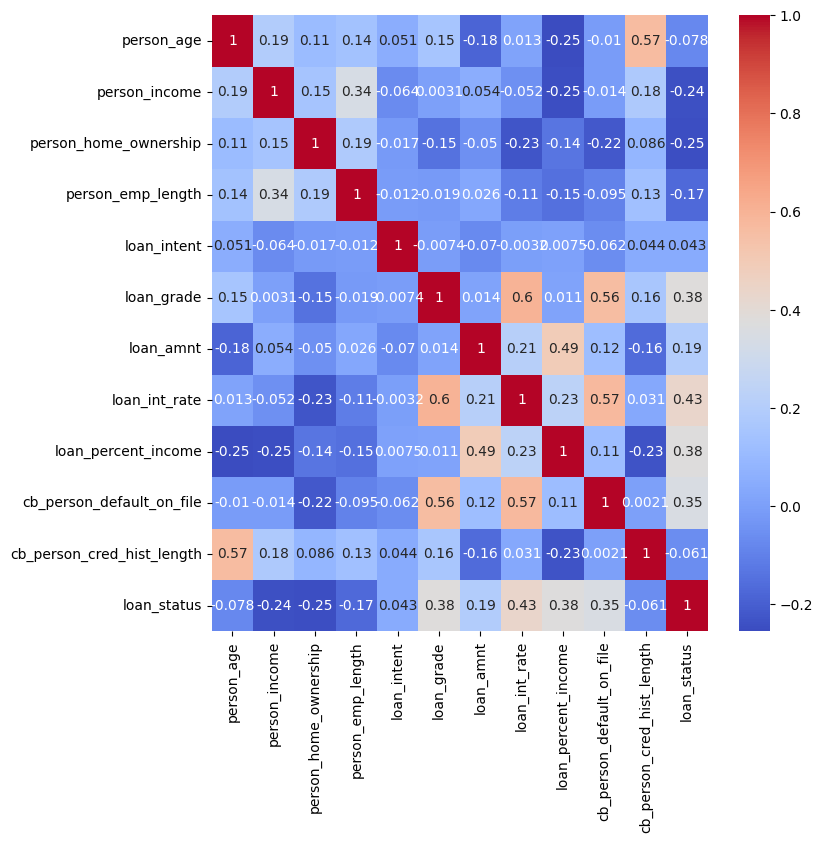

In [297]:
train['person_home_ownership'] = train['person_home_ownership'].map({'OTHER': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3})
train['loan_intent'] = train['loan_intent'].map({'DEBTCONSOLIDATION': 0, 'VENTURE': 1, 'PERSONAL': 2, 'EDUCATION': 3, 'HOMEIMPROVEMENT': 4, 'MEDICAL': 5})
train['loan_grade'] = train['loan_grade'].map({'B': 0, 'A': 1, 'C': 2, 'F': 3, 'G': 4, 'D': 5, 'E': 6})
train['cb_person_default_on_file'] = train['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

test['person_home_ownership'] = test['person_home_ownership'].map({'OTHER': 0, 'RENT': 1, 'MORTGAGE': 2, 'OWN': 3})
test['loan_intent'] = test['loan_intent'].map({'DEBTCONSOLIDATION': 0, 'VENTURE': 1, 'PERSONAL': 2, 'EDUCATION': 3, 'HOMEIMPROVEMENT': 4, 'MEDICAL': 5})
test['loan_grade'] = test['loan_grade'].map({'B': 0, 'A': 1, 'C': 2, 'F': 3, 'G': 4, 'D': 5, 'E': 6})
test['cb_person_default_on_file'] = test['cb_person_default_on_file'].map({'N': 0, 'Y': 1})

cor = train.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(cor, annot=True, cmap='coolwarm')
plt.show()

In [298]:
train['loan_grade'] = train['loan_grade'].map({0: 'B', 1: 'A', 2: 'C', 3: 'F', 4: 'G', 5: 'D', 6: 'E'})
train['person_income'] = train['person_income'].apply(lambda i: 1 if i>=100_000 else 0)
train['person_emp_length'] = train['person_emp_length'].apply(lambda i: 1 if i>=12 else 0)

test['loan_grade'] = test['loan_grade'].map({0: 'B', 1: 'A', 2: 'C', 3: 'F', 4: 'G', 5: 'D', 6: 'E'})
test['person_income'] = test['person_income'].apply(lambda i: 1 if i>=100_000 else 0)
test['person_emp_length'] = test['person_emp_length'].apply(lambda i: 1 if i>=12 else 0)

temp = sorted(train['loan_grade'].unique())
for _ in temp:
    train[f'grade_{_}'] = (train['loan_grade'] == _).astype(int)
    test[f'grade_{_}'] = (test['loan_grade'] == _).astype(int)
train = train.drop(columns=['loan_grade'])
test = test.drop(columns=['loan_grade'])

In [299]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G
0,24.0,0,0,0,0,19628.0,11.280424,0.186975,0,2.0,0,0,1,0,0,0,0,0
1,27.0,0,1,0,0,5600.0,7.612955,0.058227,0,4.0,0,1,0,0,0,0,0,0
2,29.0,1,2,1,1,4646.0,7.307318,0.092135,0,7.0,0,1,0,0,0,0,0,0
3,29.0,0,2,0,2,3963.0,7.519796,0.059832,0,6.0,0,1,0,0,0,0,0,0
4,30.0,0,2,1,1,11829.0,7.738875,0.108688,0,7.0,0,1,0,0,0,0,0,0


In [300]:
train_x = train.drop(columns=['loan_status']).values.astype(np.float32) # to be input_body = 17
train_y = train['loan_status'].values.astype(np.float32).reshape(-1, 1)

x_tensor = torch.tensor(train_x)
y_tensor = torch.tensor(train_y)

test_x = test.values.astype(np.float32)
x_test_tensor = torch.tensor(test_x)

In [301]:
class neural_network(nn.Module):
  def __init__(self, input_body):
    super(neural_network, self).__init__()
    self.layer1 = nn.Linear(input_body, 64)
    self.layer2 = nn.Linear(64, 16)
    self.output = nn.Linear(16, 1)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = torch.relu(self.layer1(x))
    x = torch.relu(self.layer2(x))

    x = self.sigmoid(self.output(x))
    return x

In [302]:
def f1_macro(y_pred, y_true, threshold=0.5):
  y_pred = y_pred.detach().numpy()
  y_true = y_true.detach().numpy()
  y_pred_class = (y_pred >= threshold).astype(int)

  f1_scores = []
  for cls in [0, 1]:
    tp = np.sum((y_true == cls) & (y_pred_class == cls))
    fp = np.sum((y_true != cls) & (y_pred_class == cls))
    fn = np.sum((y_true == cls) & (y_pred_class != cls))

    if (tp + tp == 0) or (tp + fn == 0): f1 = 0.0
    else :
      precision = tp / (tp + fp)
      recall = tp / (tp + fn)

      if precision + recall == 0: f1 = 0.0
      else: f1 = 2 * (precision * recall) / (precision + recall)
    f1_scores.append(f1)

  return np.mean(f1_scores)

In [303]:
model = neural_network(train_x.shape[1])
error = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch, n = 30_000, 5000
for i in range(0, epoch):
  # Forward pass
  y_pred = model(x_tensor)
  loss_bce = error(y_pred, y_tensor)
  loss_f1 = f1_macro(y_pred, y_tensor)

  # Backward + Optimize
  optimizer.zero_grad()
  loss_bce.backward()
  optimizer.step()

  if i == (n-1):
    print(f"Epoch [{i+1}/{epoch}] | Loss(F1): {loss_f1:.4f} | Loss(BCE): {loss_bce:.4f}")
    n += 5000
torch.save(model.state_dict(), 'my_weight_model.pth')

Epoch [5000/30000] | Loss(F1): 0.6981 | Loss(BCE): 0.5490
Epoch [10000/30000] | Loss(F1): 0.6845 | Loss(BCE): 0.4203
Epoch [15000/30000] | Loss(F1): 0.6524 | Loss(BCE): 0.4347
Epoch [20000/30000] | Loss(F1): 0.7527 | Loss(BCE): 0.4089
Epoch [25000/30000] | Loss(F1): 0.7594 | Loss(BCE): 0.3985
Epoch [30000/30000] | Loss(F1): 0.7630 | Loss(BCE): 0.3912


In [304]:
with torch.no_grad():
    pred = model(x_test_tensor)
    predicted = (pred >= 0.5).float()
    y_hat = predicted.squeeze().numpy().astype(int)
y_hat = pd.DataFrame(y_hat)
summarize = pd.concat([temp_test_id, y_hat], axis=1)
summarize.columns = ['id', 'loan_status']
summarize.to_csv('My_Answer.csv', index=False)
summarize

,id,loan_status
0,31641,0
1,31642,1
2,31643,0
3,31644,1
4,31645,0
...,...,...
7905,39546,0
7906,39547,0
7907,39548,0
7908,39549,0


In [305]:
summarize['loan_status'].unique()

array([0, 1])